# Računalniški vid v robotiki

Da uspešno opravite vajo, jo morate predstaviti asistentu na vajah. Pri nekaterih nalogah so vprašanja, ki zahtevajo skiciranje, ročno računanje in razmislek. Končno rešitev na takšna vprašanja vpišite v predvideni prostor, postopek reševanja pa razložite asistentu na vajah. Deli nalog, ki imajo pred navodilom navedene točke, niso obvezni. Brez njih lahko za celotno vajo dobite največ **75** točk (zgornja meja je **100** točk kar pomeni oceno 10). V nekaterih vajah je dodatnih nalog več in vam ni potrebno opraviti vseh.

Zaključna vaja povezuje robotiko in računalniško zaznavanje. Vaš robotski sistem boste nadgradili s kamero, ki bo opazovala delovno površino robotskega manipulatorja, preko zajete slike pa boste lahko na površini zaznali objekte glede na njihovo barvo in obliko. Preko homografske preslikave boste točke iz koordinatnega prostora slike pretvorili v prostor robota ter mu ukazali, naj se premakne tako, da pokaže na ustrezni predmet.

In [6]:
import cv2
import manus
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Cursor

%matplotlib widget
#%matplotlib notebook

In [ ]:
# Run this cell to download the data used in this exercise
# import zipfile, urllib.request, io
# zipfile.ZipFile(io.BytesIO(urllib.request.urlopen("https://data.vicos.si/lukacu/rrz/vaja4.zip").read())).extractall()

## Naloga 1 - Homografska transformacija

Homografska transformacija je pogosto uporabljana v projektivni geometriji. Predstavlja projekcijo ene ravnine v prostoru na drugo ravnino v prostoru. Naj bo $\mathbf{x}_w$ točka na ravnini v svetovnih koordinatah in naj bo $\mathbf{x}_c$ točka v koordinatah slikovne ravnine. Natančneje, $\mathbf{x}_w=[ x_w, y_w, 1 ]^T$ in $\mathbf{x}_c=[ x_c, y_c, 1 ]^T$. Projekcijo točke svetovnih koordinatah $\mathbf{x}_w$ v točko $\mathbf{x}_c$, ki se nahaja na slikovni ravnini senzorja, preslikamo s homografijo $\mathbf{H}_w^c$ po enačbi

$$
    \mathbf{x}_c = \lambda \mathbf{H}_w^c \mathbf{x}_w,
$$

kjer je homografija matrika velikosti $3 \times 3$ elementov

$$
    \mathbf{H}_w^c = \left[ {\begin{array}{}
{{h_{11}}}&{{h_{12}}}&{{h_{13}}}\\
{{h_{21}}}&{{h_{22}}}&{{h_{23}}}\\
{{h_{31}}}&{{h_{32}}}&{{h_{33}}}
\end{array}} \right] .
$$

Relacija v zgornji enačbi je zapisana v homogenih koordinatah in je zato napisana le do skale natančno. V praksi ima matrika $\mathbf{H}_w^c$ samo 8 *prostih* parametrov in ne 9, saj zadnji element postavimo na ena, $h_{33}=1$. Če hočemo točke v koordinatah slike $\mathbf{x}_c$ preslikati v točko $\mathbf{x}_c$, ki se nahaja na svetovnih koordinatah, moramo uporabiti inverz homografije $\mathbf{H}_c^w = (\mathbf{H}_w^c)^{-1}$.

V naslednjih nalogah boste preizkusili homografsko transformacijo na pripravljenih podatkih.

* Naložite sliko iz datoteke ``camera1.jpg`` ter homografsko matriko iz datoteke ``camera1.txt`` z uporabo spodaj priložene funkcije ``load_h``. Prikažite sliko ter na njej izrišite mrežo točk z desetimi vrsticami in desetimi stolpci.

In [7]:
def load_h(txt_file_path):
    with open(txt_file_path, 'r') as f:
        l = [[float(num) for num in line.split(',')] for line in f]    
    return np.array(l)

Grid points shape: (100, 2)


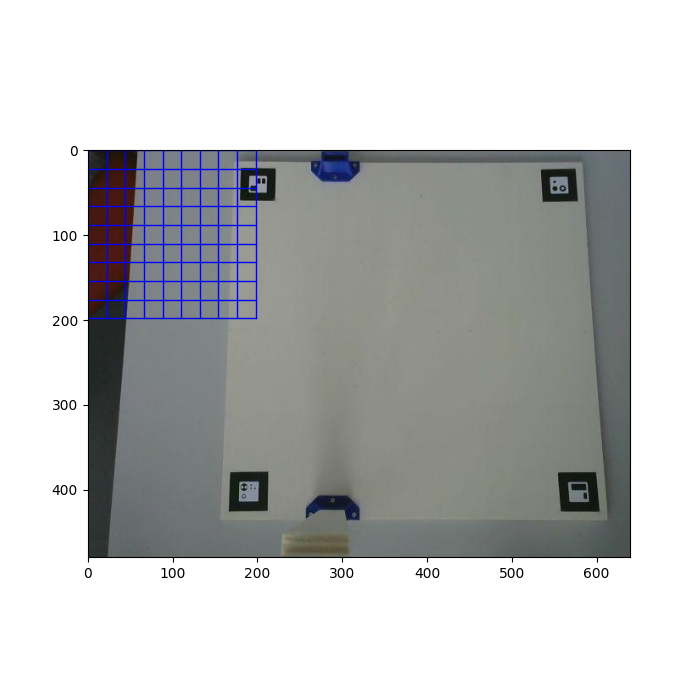

In [16]:
A_camera = cv2.imread('material/camera1.jpg')
A_camera = cv2.cvtColor(A_camera, cv2.COLOR_BGR2RGB)
h_camera = load_h("material/camera1.txt")

# Create empty lists to store our points
grid_points = []

rows = 10
cols = 10
cell_size = 22

# Create grid points with nested loops
for x in range(0, cell_size * cols, cell_size):  # from 0 to 200 with step 20
    for y in range(0, cell_size * rows, cell_size):  # from 0 to 200 with step 20
        grid_points.append([x, y])

# Convert list to numpy array
grid_points = np.array(grid_points)
print("Grid points shape:", grid_points.shape)       # Should be (100, 2)

# Reshape original grid_points
original_x = grid_points[:, 0].reshape(rows, cols)
original_y = grid_points[:, 1].reshape(rows, cols)

# Display the image and points
plt.figure(figsize=(7, 7))
plt.imshow(A_camera)

for i in range(cols):
   plt.plot(original_x[:, i], original_y[:, i], 'b-', linewidth=1)

# Draw horizontal lines
for i in range(rows):
   plt.plot(original_x[i, :], original_y[i, :], 'b-', linewidth=1)
    
plt.show()

* Izris spremenite tako, da točke črt pred izrisom preslikate s prebrano homografsko matriko. Pri tem morate točke najprej preslikati v homogene koordinate (na konec vektorja dodati vrednost $1$), jo pomnožiti z matriko, nato pa *točko pretvoriti nazaj iz homogenih koordinat* tako, da vektor delimo z vrednostjo zadnjega elementa ter tega nato odstranimo. Spodaj je prikazan zaželeni rezultat, kjer modra mreža prikazuje rezultat zgornje naloge, rdeča mreža pa rezultat te naloge.

\begin{equation*}
p_S = [ x, y, 1 ], \\  p_H = H \ast p_S = [ x_H, y_H, z_H ], \\ p_D = \big[ \frac{x_H}{z_H}, \frac{y_H}{z_H} \big]
\end{equation*}

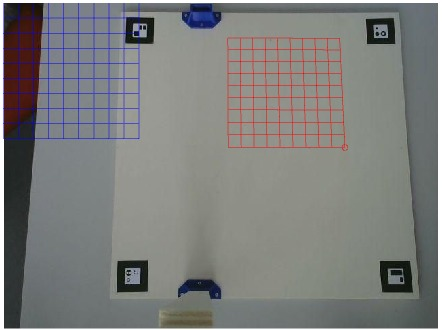

[[-8.6270e-01  7.0935e-02  5.0349e+02]
 [-2.3857e-03 -7.9373e-01  2.1294e+02]
 [-5.9396e-06  2.2106e-04  1.0000e+00]]
(100, 3)


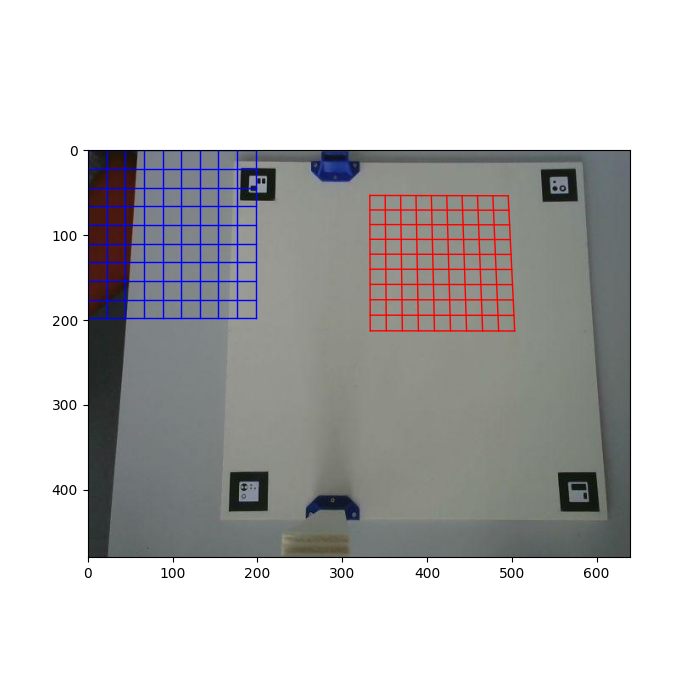

In [17]:
print(h_camera)

grid_points = np.array(grid_points)

# 3x3 matrix -> homogenus tranfromation (roation, scale, translation)
# 1. Converte global/world coordiantes to homogenus [x, y, 1]
# 2. Mulltiplay with homographic matrix -> Image coordinates!
# [x']   [h11 h12 h13] [x]
# [y'] = [h21 h22 h23] [y]
# [w']   [h31 h32 h33] [1]
# 3. Image coordiantes (homogenus) -> [x'/w', y'/w']

# p_image = H @ P_world 
# where:
# p_image - point in image coordinates (where it appears in the picture)
# P_world - point in world/global coordinates (real world position)
# H - homography matrix (3x3) that maps from world to image

# World coordinates (including homogeneous coordinate) (100, 3)
p_world_homogeneous = np.zeros((len(grid_points), 3))  # Create empty array
p_world_homogeneous[:, 0] = grid_points[:, 0]  # Copy x coordinates
p_world_homogeneous[:, 1] = grid_points[:, 1]  # Copy y coordinates
p_world_homogeneous[:, 2] = 1  # Set last column to ones

print(p_world_homogeneous.shape)

# Multiply by homography matrix
p_image_homogeneous_t = h_camera @ p_world_homogeneous.T
p_image_homogeneous = p_image_homogeneous_t.T


# Convert back from homogeneous coordinates to get pixel coordinates
p_image_x = p_image_homogeneous[:, 0] / p_image_homogeneous[:, 2]  # all x coordinates
p_image_y = p_image_homogeneous[:, 1] / p_image_homogeneous[:, 2]  # all y coordinates

# Reshape to 10x10 grid
x_grid = p_image_x.reshape(rows, cols)
y_grid = p_image_y.reshape(rows, cols)

# Display the image and points
plt.figure(figsize=(7, 7))
plt.imshow(A_camera)

# Draw transformed grid in red
# Draw vertical lines
for i in range(cols):
   plt.plot(x_grid[:, i], y_grid[:, i], 'r-', linewidth=1)

# Draw horizontal lines
for i in range(rows):
   plt.plot(x_grid[i, :], y_grid[i, :], 'r-', linewidth=1)

# Draw original grid in blue
# Draw vertical lines
for i in range(cols):
   plt.plot(original_x[:, i], original_y[:, i], 'b-', linewidth=1)

# Draw horizontal lines
for i in range(rows):
   plt.plot(original_x[i, :], original_y[i, :], 'b-', linewidth=1)
    
plt.show()

* Oglejmo si sedaj še preslikavo v drugo smer. To tehniko lahko uporabimo za preslikavo iz slikovnih koordinat v svetovne koordinate. Matriko $H$ invertirajte z uporabo funkcije ``np.linalg.inv``. Prikažite sliko ter z uporabo funkcije ``ginput`` knjižnice *matplotlib* vnesite eno ali več točk s klikom na sliko. Dane točke preslikajte z uporabo inverza matrike $H$ iz ravnine kamere v svetovne koordinate ter jih prikažite v novem grafu z uporabo funkcije plot.

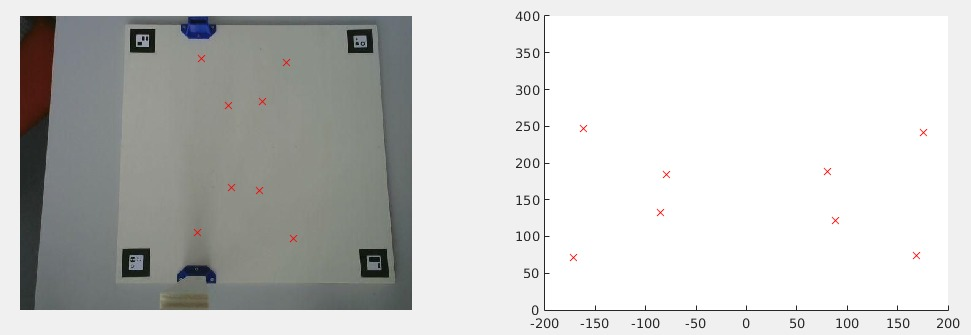

In [ ]:
# click_points.py

## Naloga 2 - Detekcija objektov

V tej nalogi boste implementirali preprosto detekcijo planarnih objektov z uporabo segmentacije, morfoloških operacij ter opisa regij. Sledite naslednjim korakom (*lahko si pomagate z detekcijo bombonov, če ste jo implementirali v okviru druge vaje*).

* Naložite sliko iz datoteke ``camera2.jpg`` ter jo prikažite na zaslonu. Z uporabo funkcije ``ginput`` določite meje poligona delovne površine kot je prikazano na spodnjem primeru. Nato za podane točke generirajte rastersko masko z uporabo funkcije ``poly2mask``, ki na vhodu sprejme koordinate poligona ter velikost rasteriziranega območja (za lažjo uporabo naj bo ta enaka velikosti slike). Če ste pri drugi vaji implementirali funkcijo ``immask``, jo sedaj uporabite za prikaz izolirane delovne površine.

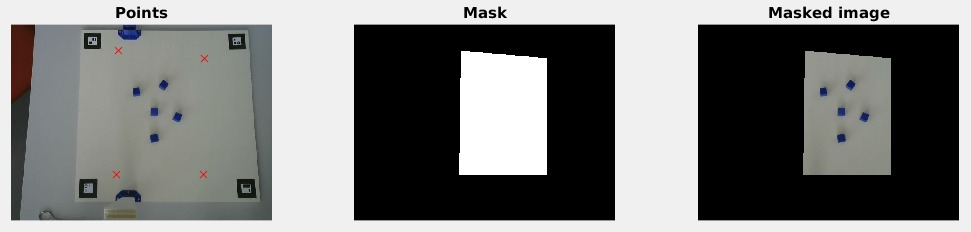

In [11]:
from skimage import draw
def poly2mask(y_coords, x_coords, shape):
    # y_coord = y koordinate poligona (vrstni red je pomemben!)
    # x_coord = x koordinate poligona (vrstni red je pomemben!)
    # shape = dimenzije maske (height, weight)
    fill_row_coords, fill_col_coords = draw.polygon(y_coords, x_coords, shape)
    mask = np.zeros(shape, dtype=np.bool)
    mask[fill_row_coords, fill_col_coords] = True
    return mask


def apply_mask(I, mask):
    mask = mask.astype("uint8")
    # Create 3D mask
    mask_3d = np.zeros_like(I)
    for i in range(3):
        mask_3d[:,:,i] = mask
    return I * mask_3d

In [ ]:
# click_mask.py

* Sliko pogleda kamere pretvorite v HSV barvni prostor ter z uporabo upragovanja določite regije modre barve. Po potrebi segmentacijo izboljšajte z uporabo morfoloških operacij *erode* in *dilate*, da se znebite šuma. Končno binarno masko združite z masko delovne površine, da odstranite morebitne napačne detekcije.

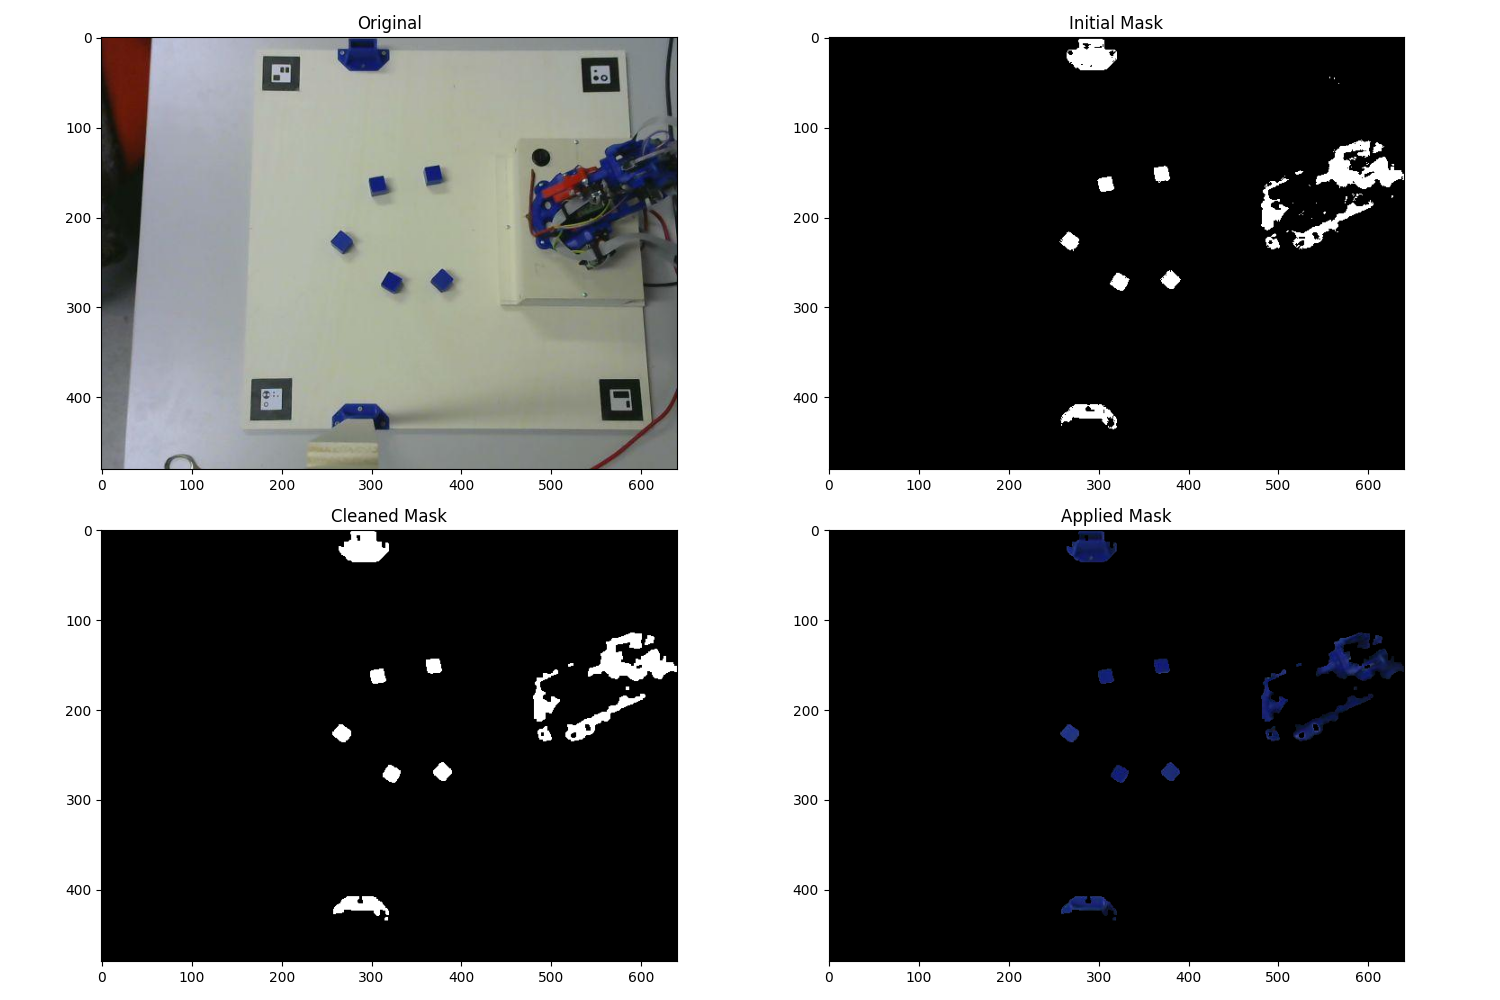

In [31]:
I_camera2 = cv2.imread("material/camera2.jpg")
I_camera2 = cv2.cvtColor(I_camera2, cv2.COLOR_BGR2RGB)
I_camera2_hsv = cv2.cvtColor(I_camera2, cv2.COLOR_RGB2HSV)

# Hue [0, 359] (circle) opencv -> [0, 179] 8bit optimization
# Low saturation - white colors
mask = (I_camera2_hsv[:,:,0] > 95) & (I_camera2_hsv[:,:,0] < 120) & (I_camera2_hsv[:,:,1] > 150)
blue_comp_binary = np.where(mask, 1, 0).astype(np.uint8)

kernel = np.ones((3, 3), np.uint8)

dilated = cv2.dilate(blue_comp_binary, kernel, iterations=1)
eroded = cv2.erode(blue_comp_binary, kernel, iterations=1)


# First close to fill gaps
blue_comp_closed = cv2.erode(cv2.dilate(blue_comp_binary, kernel), kernel)
# Then open to remove noise
blue_comp_clean = cv2.dilate(cv2.erode(blue_comp_closed, kernel), kernel)

plt.figure(figsize=(15, 10))

# First row
plt.subplot(221)
plt.imshow(I_camera2)  # Convert BGR to RGB for correct colors
plt.title("Original")

plt.subplot(222)
plt.imshow(blue_comp_binary, cmap='gray')
plt.title("Initial Mask")

# Second row
plt.subplot(223)
plt.imshow(blue_comp_clean, cmap='gray')  # The cleaned mask (after morphological operations)
plt.title("Cleaned Mask")

plt.subplot(224)
plt.imshow(apply_mask(I_camera2, blue_comp_clean))
plt.title("Applied Mask")

plt.tight_layout()
plt.show()

* Masko razdelite na posamezne komponente. Za vsako komponento izračunajte centroid, ki jih nato prikažite kot točke na izvorni sliki iz datoteke ``camera2.jpg``.

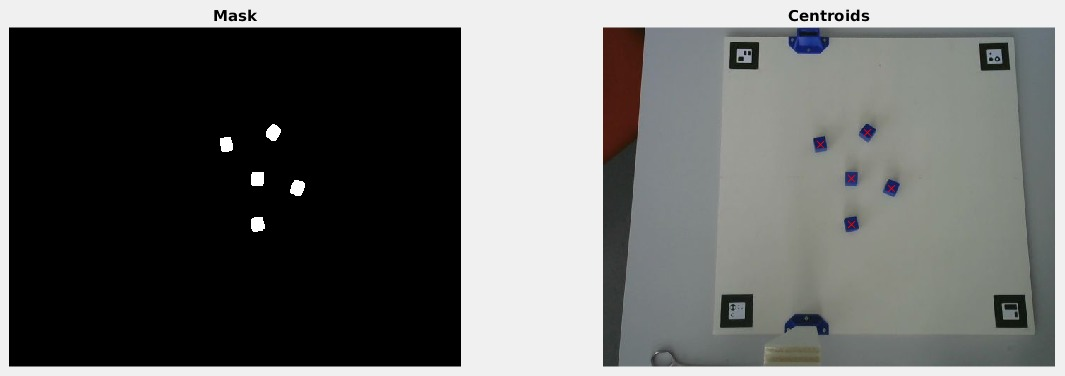

In [ ]:
# click_centroid.py

## Naloga 3 - Krmiljenje robotskega manipulatorja

Ta naloga združeje vse znanje pridobljeno tekom prvih treh nalog. Za to nalogo morate imeti vzpostavljno virtualno okolje za uporabo manipulatorja.

* Vzpostavite sistem za dostop do manipulatorja in kamere. Preučite skripto ``manus.py`` (osredotočite se predvsem na class *Camera* ter funkciji ``position`` in ``image``) in si oglajte spodaj priloženo kodo, ki demonstrira kako lahko iz kamere na robotskem manipulatorju pridobimo sliko ter jo prikažemo na zaslonu.

In [ ]:
server = manus.Server(address='192.168.56.101', port=80)

camera = manus.Camera(server)
img = camera.image()

print(img)

plt.figure()
plt.imshow(img[0])

* Z uporabo priložene funkcije ``get_homography_matrix`` preberite homografsko matriko. Homografsko matriko uporabite za izris kvadrata z $(x, y)$ koordinatami $(100, -200)$, $(100, 200)$, $(300, 200)$, $(300, -200)$ v svetovnem koordinatnem sistemu delovne ravnine.

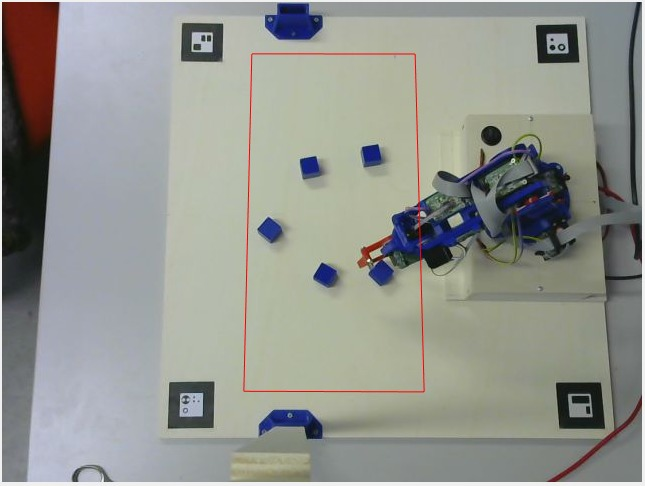

In [ ]:
def get_homography_matrix(camera):
    camera_position = camera.position()
    intrinsics = camera.intrinsics
    rotation_matrix = camera_position[0]
    translation_vector = camera_position[1]
    
    transform = np.hstack((rotation_matrix, np.transpose(translation_vector)))
    projective = np.matmul(intrinsics, transform);
    homography = projective[:, [0, 1, 3]];
    homography /= homography[2, 2];
    
    return homography

In [ ]:
# TODO

* Skripto razširite tako, da bo na sliki zaznala modre kocke ter prikazala njihove centroide. Po potrebi lahko določite tudi masko delovne površine (ker je kamera v scenariju statična, lahko to masko določite enkrat ter jo potem uporabljate večkrat).

In [ ]:
# TODO

* Preslikajte vse točke iz koordinatnega sistema kamere v koordinatni sistem delovne površine. V zanki potujte preko seznama točk ter manipulator premikajte tako, da bo s koncem prijemala pokazal na posamezni zaznani objekt na delovni površini. Ker v $3D$ prostoru robotskega manipulatorja zaznane točke ležijo na delovni površini (koordinata v smeri $z$ je $0$) kot take niso neposredno primerne za podajanje cilja robotskemu manipulatorju. Zato točko preoblikujte tako, da ji podate novo višino od delovne površine (npr. $z = 30$). Take točke bodo od ravnine oddaljene 3 cm.

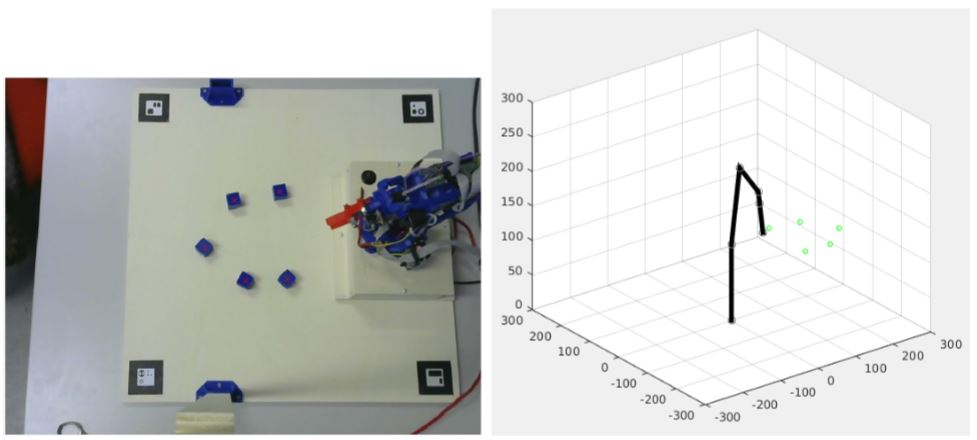

In [ ]:
# TODO

* Razširite detekcijo objektov tako, da bo zaznala kocke dveh barv, modre in črne. Manipulator naj nato pokaže vse zaznane modre kocke z zaprtim prijemalom, nato pa še črne kocke z odprtim prijemalom.

In [ ]:
# TODO

* **(5 točk)** Napišite algoritem, ki bo krmilil manipulator tako, da bo sledil izbranemu predmetu preko kamere. Pri tem lahko predpostavite, da je predmet blizu delovne površine (z = 0), lahko si tudi izberete njegovo barvo ali druge lastnosti.

In [ ]:
# TODO

* **(10 točk)** Prilagodite algoritem iz prejšnjih točk tako, da bo manipulator zaznane kocke dveh barv (si lahko izberete vnaprej), ki so na začetku razporejene naključno, razporedil glede na barvo na levo in desno stran delovne površine. Pri tem bodite pozorni, da kocke ne bodo postavljene ena čez drugo.

In [ ]:
# TODO

* **(10 točk)** Prilagodite algoritem iz prejšnjih točk tako, da bo manipulator zaznane kocke (vsaj štiri kocke) zložil eno na drugo v stolp. 